# INTRODUCTION
## NYC Taxi Ride Duration Prediction

To improve the efficiency of taxi dispatching, it is important to predict how long a driver will have his taxi occupied.  If a dispatcher knows when a current ride is likely to end, they would be enabled to assign the right driver to each pick-up request.

The goal of this exercise to to predict taxi ride durations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

# Importing the train test split function
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
# from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Get Data

In [2]:
df = pd.read_csv('../../data/nyc_taxi_trip_duration.csv')

## Quick Look at Data

In [3]:
df.shape

(729322, 11)

In [4]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

Notes:

**id** is not useful and can be dropped
**vendor_id** is nominal integer (compared to an ordered value)
**pickup_datetime** and **dropoff_datetime** are stored as objects which must be converted to datetime
**store_and_fwd_flag** is categorical

## Data Dictionary

**Demographic information of Customer & Vendor**
- id : a unique identifier for each trip
- vendor_id : a code indicating the provider associated with the trip record
- passenger_count : the number of passengers in the vehicle (driver entered value)
**Information about the Trip**
- pickup_longitude : date and time when the meter was engaged
- pickup_latitude : date and time when the meter was disengaged
- dropoff_longitude : the longitude where the meter was disengaged
- dropoff_latitude : the latitude where the meter was disengaged
- store_and_fwd_flag : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- trip_duration : (target) duration of the trip in seconds

There are 10 features and 1 target variable which is trip_duration

## Numerical Data

In [7]:
df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  729322.000000    729322.000000     729322.000000    729322.000000   
mean        1.535403         1.662055        -73.973513        40.750919   
std         0.498745         1.312446          0.069754         0.033594   
min         1.000000         0.000000       -121.933342        34.712234   
25%         1.000000         1.000000        -73.991859        40.737335   
50%         2.000000         1.000000        -73.981758        40.754070   
75%         2.000000         2.000000        -73.967361        40.768314   
max         2.000000         9.000000        -65.897385        51.881084   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      729322.000000     729322.000000   7.293220e+05  
mean          -73.973422         40.751775   9.522291e+02  
std             0.069588          0.036037   3.864626e+03  
min          -121.933304         32.181141   1.000000e+00  
25%           -73.991318         40.735931   3.970000e+02  
50%           -73.979759         40.754509   6.630000e+02  
75%           -73.963036         40.769741   1.075000e+03  
max           -65.897385         43.921028   1.939736e+06

Looking at the min and max values one sees:
- most rides have few passengers
- trip durations may have 1 second rides - does tha tmake sense?
- there may be outliers in the trip durations on the high side
- there may be some trip wher ehte distance was much longer than average

In [8]:
pd.isnull(df).sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values.

## Data Preprocessing

First, convert date-times.  Also add some useful variations to the data data.  This can be used to see if there are any interesting patterns.

In [9]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [10]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

df['pickup_hour_of_day'] = df['pickup_datetime'].dt.hour
df['dropoff_hour_of_day'] = df['dropoff_datetime'].dt.hour

In [11]:
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_day dropoff_day  \
0         40.771164                  N            400     Monday      Monday   
1         40.694931                  N           1100     Friday      Friday   
2         40.774918                  N           1635     Sunday      Sunday   
3         40.780628                  N           1141    Tuesday     Tuesday   
4         40.740631                  N            848  Wednesday   Wednesday   

   pickup_hour_of_day  dropoff_hour_of_day  
0                  16                   16  
1                  23                   23  
2                  17                   18  
3                   9                   10  
4                   6                    6

In [12]:
def UVA_days(df,var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,3),dpi=100)
    
    for j,i in enumerate(var_group):
        
        plt.subplot(1, size, j + 1)
        sns.countplot(x = i, data = df)
        plt.xlabel(f'{i}', fontsize = 10)
        plt.ylabel('frequency')

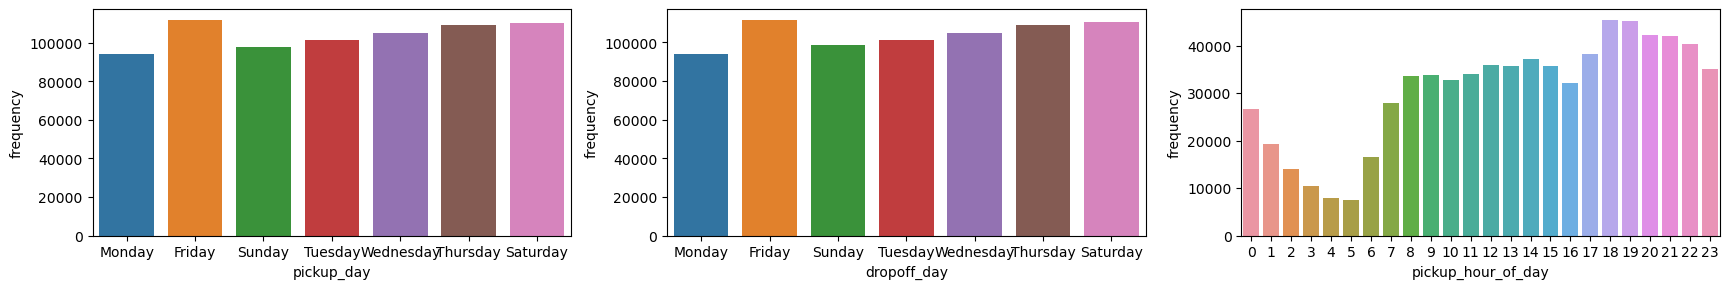

In [13]:
UVA_days(df, ['pickup_day', 'dropoff_day', 'pickup_hour_of_day'])

Fridays enjoyed the most taxi trips; Mondays experienced the fewest.  Trips pickup in the evening. Nothing really to do further.  Let's evaluate a few other variables like **passenger_count**, **vendor_id**, and **store_and_fwd_flag**.

Text(0, 0.5, 'Frequency')

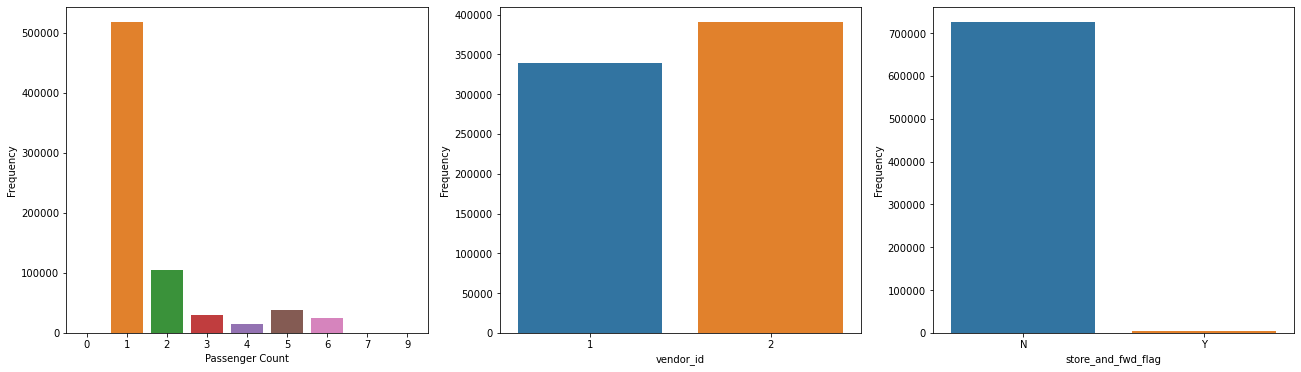

In [14]:
# Binary Features
plt.figure(figsize = (22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

- Most of the trips involve only 1 passenger.  There appear to be no trips with more than 6 passengers.  Will evaluate next.
- Vendor 2 has more trips compared to vendor 1
- The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing the data

### passenger_counts

In [15]:
df.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
9         1
7         1
Name: passenger_count, dtype: int64

Because there are so few records, remove records with 0, 7 and 9 passengers.

In [16]:
df = df[df.passenger_count <= 6]
df = df[df.passenger_count != 0]

### Evaluate Trip Durations

In [17]:
print('The value of largest trip duration values are: \n {} \n'.format(df['trip_duration'].nlargest(10)))
print('The the number of records with 1 second trips is {}.'.format(len(df[df['trip_duration']==1 ])))

The value of largest trip duration values are: 
 21813     1939736
259437      86391
119185      86387
177225      86378
496391      86377
90557       86369
673847      86369
163178      86367
179065      86365
248675      86364
Name: trip_duration, dtype: int64 

The the number of records with 1 second trips is 12.


The extreme values seem irrational.  Remove them (since there are not that mny of them).

In [18]:
df = df[df.trip_duration != df.trip_duration.max()]
df = df[df.trip_duration != df.trip_duration.min()]

Trip durations in seconds are not easilty understood.  Let's change to durations in minutes.  Also convert to hours.

In [19]:
df['trip_duration_minutes']=df['trip_duration']/60
df['trip_duration_minutes']

0          6.666667
1         18.333333
2         27.250000
3         19.016667
4         14.133333
            ...    
729317     4.933333
729318     5.250000
729319    11.216667
729320     7.450000
729321    20.400000
Name: trip_duration_minutes, Length: 729274, dtype: float64

In [20]:
df['trip_duration_hours']=df['trip_duration']/3600
df['trip_duration_hours']

0         0.111111
1         0.305556
2         0.454167
3         0.316944
4         0.235556
            ...   
729317    0.082222
729318    0.087500
729319    0.186944
729320    0.124167
729321    0.340000
Name: trip_duration_hours, Length: 729274, dtype: float64

Since we have duration and lat/long, let's calcualte distances and speed

In [21]:
# Installed 12/21/20 
#!pip install geopy

In [22]:
# Code to determine distance from Lat Long
# Use Python package geopy (https://pypi.org/project/geopy/
# Note distance is between 2 points, not the roads travelled.
from geopy.distance import great_circle

def distance_travelled(df):
    start = (df['pickup_latitude'], df['pickup_longitude'])
    stop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return great_circle(start, stop).miles

df['distance'] = df.apply(lambda x: distance_travelled(x), axis = 1)

In [23]:
# In addition to distance, may as well claculate average speed too
df['speed'] = (df.distance/(df.trip_duration_minutes/60))

In [24]:
df['speed'].sort_values(ascending = False).nlargest(20)

244913    3504.845423
654569    2539.368708
146590     876.149993
67268      874.957018
267279     839.934450
697620     804.695388
324029     786.356721
407313     773.035025
695286     707.706217
544417     680.689600
495047     589.613609
531216     575.866132
441429     485.503470
621372     393.621536
691498     362.716198
200522     350.582606
256315     339.328836
512755     296.751679
617999     263.996643
520778     236.643482
Name: speed, dtype: float64

In [25]:
print('There are {} records where the speed is greater than 80 mph.\n'.format(len(df[df['speed'] > 80])))

There are 60 records where the speed is greater than 80 mph.



Remove the speeds greater than 80 mph - no ne should be driving that fast!

In [26]:
df = df[df.speed < 81]

<AxesSubplot:xlabel='speed'>

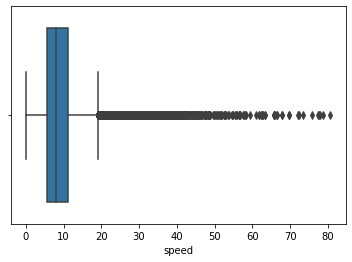

In [27]:
sns.boxplot(df['speed'])

In [28]:
df['distance'].sort_values(ascending = False)

490372    107.515610
310115     84.056471
99568      72.387624
289975     63.216093
564421     60.637346
             ...    
190386      0.000000
429159      0.000000
398015      0.000000
266761      0.000000
382621      0.000000
Name: distance, Length: 729215, dtype: float64

Some trips seem much longer than others but it is poosible.  Perhaps a trip from the airport to the end of Long Island.

What does our data look like now?

In [29]:
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_day dropoff_day  \
0         40.771164                  N            400     Monday      Monday   
1         40.694931                  N           1100     Friday      Friday   
2         40.774918                  N           1635     Sunday      Sunday   
3         40.780628                  N           1141    Tuesday     Tuesday   
4         40.740631                  N            848  Wednesday   Wednesday   

   pickup_hour_of_day  dropoff_hour_of_day  trip_duration_minutes  \
0                  16                   16               6.666667   
1                  23                   23              18.333333   
2                  17                   18              27.250000   
3                   9                   10              19.016667   
4                   6                    6              14.133333   

   trip_duration_hours  distance      speed  
0             0.111111  0.745070   6.705632  
1             0.305556  2.565714   8.396883  
2             0.454167  4.505415   9.920181  
3             0.316944  1.467120   4.628950  
4             0.235556  2.689630  11.418241

Still have some work to do:

- There are records where the speed is 0.  That does not make sense.
- There are records where distance is 0.
- There are records with no pickup/dropoff times.

In [30]:
df = df[df.speed != 0]
df = df[df.speed != 0]
df = df[df.dropoff_hour_of_day != 0]
df = df[df.distance != 0]

df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_day dropoff_day  \
0         40.771164                  N            400     Monday      Monday   
1         40.694931                  N           1100     Friday      Friday   
2         40.774918                  N           1635     Sunday      Sunday   
3         40.780628                  N           1141    Tuesday     Tuesday   
4         40.740631                  N            848  Wednesday   Wednesday   

   pickup_hour_of_day  dropoff_hour_of_day  trip_duration_minutes  \
0                  16                   16               6.666667   
1                  23                   23              18.333333   
2                  17                   18              27.250000   
3                   9                   10              19.016667   
4                   6                    6              14.133333   

   trip_duration_hours  distance      speed  
0             0.111111  0.745070   6.705632  
1             0.305556  2.565714   8.396883  
2             0.454167  4.505415   9.920181  
3             0.316944  1.467120   4.628950  
4             0.235556  2.689630  11.418241

In [31]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_hour_of_day',
       'dropoff_hour_of_day', 'trip_duration_minutes', 'trip_duration_hours',
       'distance', 'speed'],
      dtype='object')

Not all of these are useful.  In fact, I thought I had already removed *id*.  Ooops.  Some of these will be highly correlated too.  For example, speed, distance, duration are related to one and other as are the lat, long and distance variables.

Will drop *trip_duration_minutes* and *trip_duration_hours*.  They were useful for plotting and determining *speed* but are not required for predcition.  Plus, the data is presented in seconds, not minutes or hours.

*store_and_fwd_flag* is not available before the start of the trip and should not be used for modelling so remove it too.

In [32]:
df2 = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration_hours', 'trip_duration_minutes', 'dropoff_hour_of_day', 'dropoff_day', 'store_and_fwd_flag'], axis = 1)
df2.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.953918        40.778873   
1          1                2        -73.988312        40.731743   
2          2                2        -73.997314        40.721458   
3          2                6        -73.961670        40.759720   
4          1                1        -74.017120        40.708469   

   dropoff_longitude  dropoff_latitude  trip_duration pickup_day  \
0         -73.963875         40.771164            400     Monday   
1         -73.994751         40.694931           1100     Friday   
2         -73.948029         40.774918           1635     Sunday   
3         -73.956779         40.780628           1141    Tuesday   
4         -73.988182         40.740631            848  Wednesday   

   pickup_hour_of_day  distance      speed  
0                  16  0.745070   6.705632  
1                  23  2.565714   8.396883  
2                  17  4.505415   9.920181  
3                   9  1.467120   4.628950  
4                   6  2.689630  11.418241

In [33]:
df2.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.953918        40.778873   
1          1                2        -73.988312        40.731743   
2          2                2        -73.997314        40.721458   
3          2                6        -73.961670        40.759720   
4          1                1        -74.017120        40.708469   

   dropoff_longitude  dropoff_latitude  trip_duration pickup_day  \
0         -73.963875         40.771164            400     Monday   
1         -73.994751         40.694931           1100     Friday   
2         -73.948029         40.774918           1635     Sunday   
3         -73.956779         40.780628           1141    Tuesday   
4         -73.988182         40.740631            848  Wednesday   

   pickup_hour_of_day  distance      speed  
0                  16  0.745070   6.705632  
1                  23  2.565714   8.396883  
2                  17  4.505415   9.920181  
3                   9  1.467120   4.628950  
4                   6  2.689630  11.418241

In [34]:
df2.dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
trip_duration           int64
pickup_day             object
pickup_hour_of_day      int64
distance              float64
speed                 float64
dtype: object

## Create Dummy Variables

Use one-hot encoding to ransform categorical varaibles to numerical one.  This is required for algorithm development.

In [35]:
df2 = pd.get_dummies(df2, columns = ['pickup_day'])
df2.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.953918        40.778873   
1          1                2        -73.988312        40.731743   
2          2                2        -73.997314        40.721458   
3          2                6        -73.961670        40.759720   
4          1                1        -74.017120        40.708469   

   dropoff_longitude  dropoff_latitude  trip_duration  pickup_hour_of_day  \
0         -73.963875         40.771164            400                  16   
1         -73.994751         40.694931           1100                  23   
2         -73.948029         40.774918           1635                  17   
3         -73.956779         40.780628           1141                   9   
4         -73.988182         40.740631            848                   6   

   distance      speed  pickup_day_Friday  pickup_day_Monday  \
0  0.745070   6.705632                  0                  1   
1  2.565714   8.396883                  1                  0   
2  4.505415   9.920181                  0                  0   
3  1.467120   4.628950                  0                  0   
4  2.689630  11.418241                  0                  0   

   pickup_day_Saturday  pickup_day_Sunday  pickup_day_Thursday  \
0                    0                  0                    0   
1                    0                  0                    0   
2                    0                  1                    0   
3                    0                  0                    0   
4                    0                  0                    0   

   pickup_day_Tuesday  pickup_day_Wednesday  
0                   0                     0  
1                   0                     0  
2                   0                     0  
3                   1                     0  
4                   0                     1

Create a correlation heatmap

<AxesSubplot:>

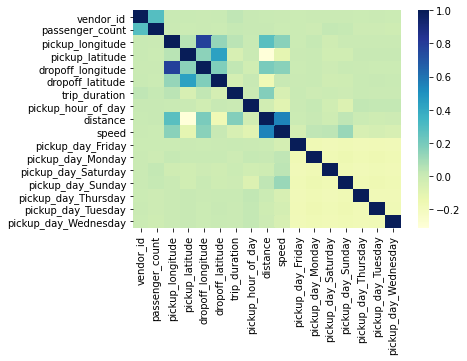

In [36]:
sns.heatmap(df2.corr(), cmap = "YlGnBu", annot = False)

Not surprisingly, *distance* and *speed* appear highly correlated.  Let's drop *speed*.

In [37]:
df2.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'pickup_hour_of_day', 'distance', 'speed', 'pickup_day_Friday',
       'pickup_day_Monday', 'pickup_day_Saturday', 'pickup_day_Sunday',
       'pickup_day_Thursday', 'pickup_day_Tuesday', 'pickup_day_Wednesday'],
      dtype='object')

In [38]:
#df2 = df2.drop(["speed"], axis = 1)

In [39]:
df2.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.953918        40.778873   
1          1                2        -73.988312        40.731743   
2          2                2        -73.997314        40.721458   
3          2                6        -73.961670        40.759720   
4          1                1        -74.017120        40.708469   

   dropoff_longitude  dropoff_latitude  trip_duration  pickup_hour_of_day  \
0         -73.963875         40.771164            400                  16   
1         -73.994751         40.694931           1100                  23   
2         -73.948029         40.774918           1635                  17   
3         -73.956779         40.780628           1141                   9   
4         -73.988182         40.740631            848                   6   

   distance      speed  pickup_day_Friday  pickup_day_Monday  \
0  0.745070   6.705632                  0                  1   
1  2.565714   8.396883                  1                  0   
2  4.505415   9.920181                  0                  0   
3  1.467120   4.628950                  0                  0   
4  2.689630  11.418241                  0                  0   

   pickup_day_Saturday  pickup_day_Sunday  pickup_day_Thursday  \
0                    0                  0                    0   
1                    0                  0                    0   
2                    0                  1                    0   
3                    0                  0                    0   
4                    0                  0                    0   

   pickup_day_Tuesday  pickup_day_Wednesday  
0                   0                     0  
1                   0                     0  
2                   0                     0  
3                   1                     0  
4                   0                     1

One last step.  Linear regression expects the target value to be continuous.  *trip_duration* is currenty class int.  Cnange to float.

In [40]:
df2["trip_duration"] = df2["trip_duration"].astype(float)
df2.dtypes

vendor_id                 int64
passenger_count           int64
pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
trip_duration           float64
pickup_hour_of_day        int64
distance                float64
speed                   float64
pickup_day_Friday         uint8
pickup_day_Monday         uint8
pickup_day_Saturday       uint8
pickup_day_Sunday         uint8
pickup_day_Thursday       uint8
pickup_day_Tuesday        uint8
pickup_day_Wednesday      uint8
dtype: object

The data looks OK.  Time to develop predictive algorithm.  I am sure during the data science process I will return to the data again.  (Perhaps not in this exercise though!)

# Taxi Trip Duration Prediction

The first model will be the simplets - calcualte the mean duration of all the values in the data set.

In [41]:
df2.loc[:, "trip_duration"].mean()

946.5906852520075

### Train Test Split to create a validation set

In [42]:
#separating independent and dependent variables
x = df2.drop(['trip_duration'], axis=1)
y = df2['trip_duration']
x.shape, y.shape

((697539, 16), (697539,))

In [43]:
x.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.953918        40.778873   
1          1                2        -73.988312        40.731743   
2          2                2        -73.997314        40.721458   
3          2                6        -73.961670        40.759720   
4          1                1        -74.017120        40.708469   

   dropoff_longitude  dropoff_latitude  pickup_hour_of_day  distance  \
0         -73.963875         40.771164                  16  0.745070   
1         -73.994751         40.694931                  23  2.565714   
2         -73.948029         40.774918                  17  4.505415   
3         -73.956779         40.780628                   9  1.467120   
4         -73.988182         40.740631                   6  2.689630   

       speed  pickup_day_Friday  pickup_day_Monday  pickup_day_Saturday  \
0   6.705632                  0                  1                    0   
1   8.396883                  1                  0                    0   
2   9.920181                  0                  0                    0   
3   4.628950                  0                  0                    0   
4  11.418241                  0                  0                    0   

   pickup_day_Sunday  pickup_day_Thursday  pickup_day_Tuesday  \
0                  0                    0                   0   
1                  0                    0                   0   
2                  1                    0                   0   
3                  0                    0                   1   
4                  0                    0                   0   

   pickup_day_Wednesday  
0                     0  
1                     0  
2                     0  
3                     0  
4                     1

In [44]:
y.head()

0     400.0
1    1100.0
2    1635.0
3    1141.0
4     848.0
Name: trip_duration, dtype: float64

In [45]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 123)

Let's now fit a linear regression model.

In [46]:
# Creating instance of Linear Regresssion
from sklearn.linear_model import LinearRegression as LR
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [47]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 403.55721893075463


In [48]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     403.77967034148577
